<a href="https://colab.research.google.com/github/tadityareddy/Aspect-Based-Sentiment-Analysis/blob/main/Aspect_Based_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [85]:
url = "https://www.amazon.in/New-Apple-iPhone-12-128GB/product-reviews/B08L5TNJHG/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"
reviewlist= []

In [86]:
def get_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

In [87]:
def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {
                'product': soup.title.text.replace('Amazon.in:Customer reviews:', '').strip(),
                'title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
                'rating': float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
                'body': item.find('span', {'data-hook': 'review-body'}).text.strip(),
            }
            reviewlist.append(review)
    except:
        pass

In [88]:
for x in range(1,100):
    soup = get_soup(f'https://www.amazon.in/New-Apple-iPhone-12-128GB/product-reviews/B08L5TNJHG/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews={x}')
    get_reviews(soup)
    if not soup.find('li',{'class':'a-disabled a-last'}):
        pass
    else:
        break

df = pd.DataFrame(reviewlist)
df.to_csv('ip12-reviews.csv')

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import re
import unicodedata as uni
from langdetect import DetectorFactory
from langdetect import detect
from easynmt import EasyNMT
import time
from plotly import express as px
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [90]:
!pip install -U easynmt
!pip install langdetect
!pip install thai_segmenter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [91]:
df = pd.read_csv("/content/drive/MyDrive/Colab Datasets/ip12-reviews.csv")

In [92]:
df.shape

(690, 5)

In [93]:
df['review']=df['title']+" "+df['body']

In [94]:
df.info

<bound method DataFrame.info of      Unnamed: 0                         product  \
0             0  Apple iPhone 12 (128GB) - Blue   
1             1  Apple iPhone 12 (128GB) - Blue   
2             2  Apple iPhone 12 (128GB) - Blue   
3             3  Apple iPhone 12 (128GB) - Blue   
4             4  Apple iPhone 12 (128GB) - Blue   
..          ...                             ...   
685         685  Apple iPhone 12 (128GB) - Blue   
686         686  Apple iPhone 12 (128GB) - Blue   
687         687  Apple iPhone 12 (128GB) - Blue   
688         688  Apple iPhone 12 (128GB) - Blue   
689         689  Apple iPhone 12 (128GB) - Blue   

                                     title  rating  \
0       An overall good premium experience       4   
1           The best Iphone in the budget.       5   
2                          Worth the price       5   
3     Everything is perfect except battery       4   
4                            Amazing Phone       5   
..                             

In [95]:
df.isnull().sum()

Unnamed: 0    0
product       0
title         0
rating        0
body          0
review        0
dtype: int64

<Figure size 1800x1440 with 0 Axes>

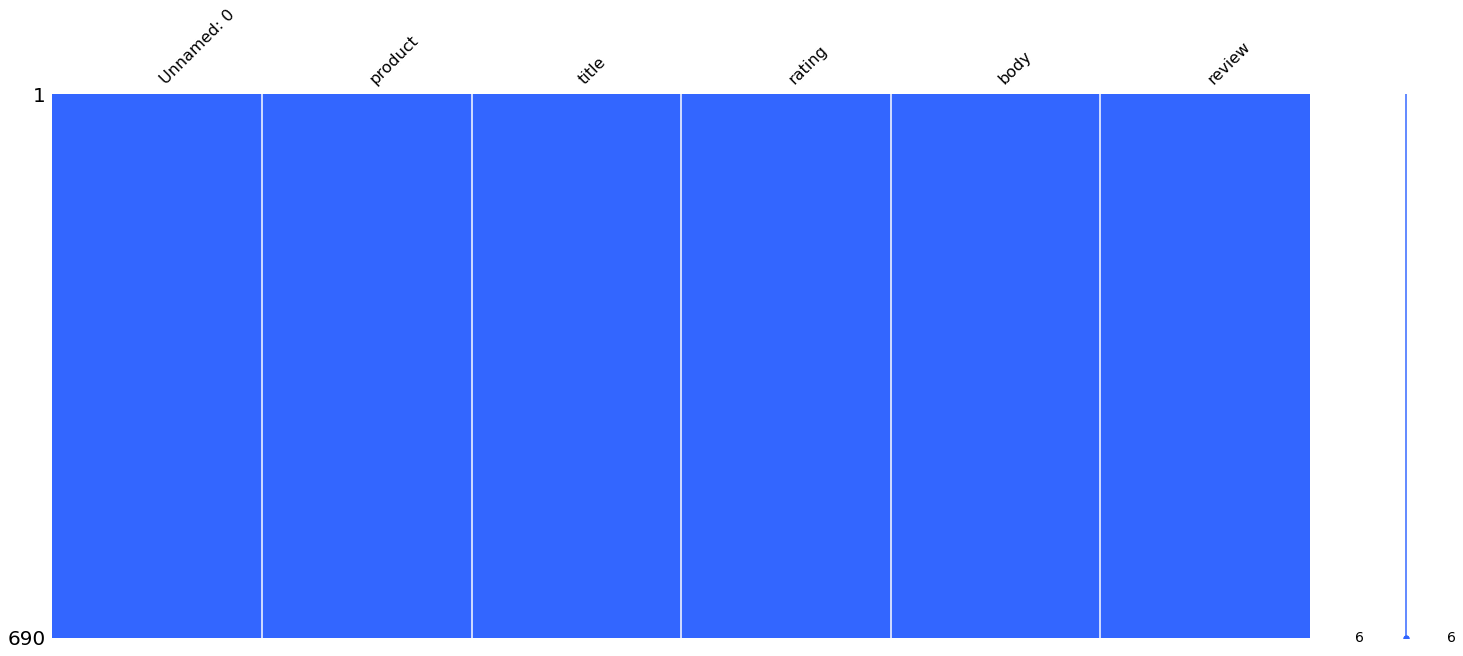

In [96]:
plt.figure(figsize=(25, 20))
msno.matrix(df, color=[0.2, 0.4, 1])
plt.show()

In [97]:
df.dropna(inplace=True, axis=0)

In [98]:
emoji = re.compile("["
u"\U0001F600-\U0001F64F"  # emoticons
u"\U0001F300-\U0001F5FF"  # symbols & pictographs
u"\U0001F680-\U0001F6FF"  # transport & map symbols
u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
u"\U00002500-\U00002BEF"  # chinese char
u"\U00002702-\U000027B0"
u"\U00002702-\U000027B0"
u"\U000024C2-\U0001F251"
u"\U0001f926-\U0001f937"
u"\U00010000-\U0010ffff"
u"\u2640-\u2642" 
u"\u2600-\u2B55"
u"\u200d"
u"\u23cf"
u"\u23e9"
u"\u231a"
u"\ufe0f"  # dingbats
u"\u3030"              "]+",re.UNICODE)

In [99]:
def clean_reviews(text):
  text = str(text).lower()
  text = re.sub(r'[!@#$(),"%^*?:;~`0-9]', ' ', text)
  text = re.sub('\[.*?\]', '', text)
  text = uni.normalize('NFKD', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub(r'[[]]', ' ', text)
  text =  re.sub(emoji,'', text)
  return text

In [100]:
df['review'] = df['review'].apply(clean_reviews)

In [101]:
def det(x):
    try:
        lang = detect(x)
    except:
        lang = 'Other'
    return lang

In [102]:
df['lang']=df['review'].apply(det)

In [103]:
DetectorFactory.seed = 0
model = EasyNMT('opus-mt')

In [104]:
def detect_and_translate(text):

  for i in range(len(df['review'])):
      if (df['lang'] == 'en').all():
        time.sleep(1)
        return text

      else:
        translate_text=model.translate(text,target_lang='en')
        time.sleep(1)
        return translate_text

In [105]:
df['review_translate'] = df['review'].apply(lambda x:detect_and_translate(x))

In [106]:
rating = df['rating'].value_counts()
ratings = rating.index
values = rating.values

In [107]:
figure = px.pie(
            df, 
            values=values, 
            names=ratings,
            hole = 0.5,
            title = 'Review Ratings Distribution'
               )
figure.show()

In [108]:
def plotWordCloud(tokens):
    sentiment_dox = ' '.join(tokens)
    word_cloud = WordCloud().generate(sentiment_dox)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

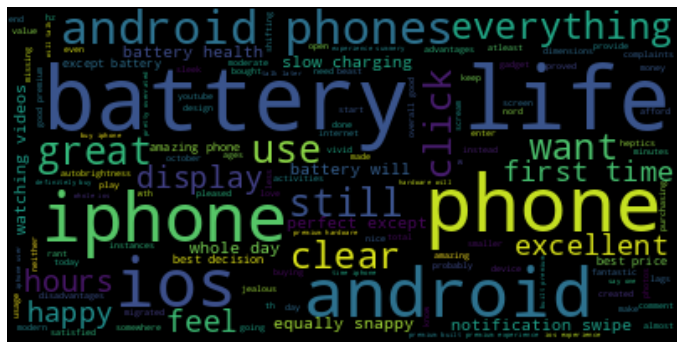

In [109]:
data_list = df['review'].tolist()
token = [token for line in data_list for token in line.split()]
plt.figure(figsize=(12,15))
plotWordCloud(token)

In [110]:
nltk.download('vader_lexicon')
sentiments = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [111]:
df["positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["review"]]
df["negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["review"]]
df["neutral"] = [sentiments.polarity_scores(i)["neu"] for i in df["review"]]
df = df[["review", "positive", "negative", "neutral"]]

In [112]:
df.head

<bound method NDFrame.head of                                                 review  positive  negative  \
0    an overall good premium experience summery  as...     0.195     0.075   
1    the best iphone in the budget. iphone    is pr...     0.175     0.060   
2    worth the price i migrated to ios after using ...     0.132     0.008   
3    everything is perfect except battery i bought ...     0.197     0.040   
4    amazing phone the iphone    has been an amazin...     0.341     0.000   
..                                                 ...       ...       ...   
685  one year ago i made the best decision before p...     0.192     0.034   
686  best price online online price is best price  ...     0.389     0.102   
687  medium battery life is not good. also many iss...     0.000     0.211   
688                         it's a brand camera superb     0.577     0.000   
689                                          good good     1.000     0.000   

     neutral  
0      0.731  
1  

In [113]:
x = sum(df["positive"])
y = sum(df["negative"])
z = sum(df["neutral"])

In [114]:
def sentiment_score(x, y, z):
    if (x>y) and (x>z):
        print("positive")
    elif (y>x) and (y>z):
        print("negative")
    else:
        print("neutral")
        
sentiment_score(x, y, z)

neutral


In [115]:
print(f"Positive: {x}")
print(f"Negative: {y}")
print(f"Neutral: {z}")

Positive: 220.66200000000063
Negative: 36.569999999999816
Neutral: 432.905999999998
